In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

2023-04-27 21:43:43.344433: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-27 21:43:43.392095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 21:43:44.634671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
x_train = train_df.iloc[:,train_df.columns != 'label']
y_train = train_df.iloc[:,train_df.columns == 'label']
y_train = y_train.values.reshape(-1)

x_test = test_df.iloc[:,test_df.columns != 'label']
y_test = test_df.iloc[:,test_df.columns == 'label']
y_test = y_test.values.reshape(-1)

In [3]:
x_train, x_train_test, y_train, y_train_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [4]:
from PIL import Image

train_data = np.array(x_train).reshape(-1, 28, 28, 1)
train_data = np.repeat(train_data, 3, axis=-1)
train_data= np.array([np.resize(img, (32, 32, 3)) for img in train_data])

train_test_data = np.array(x_train_test).reshape(-1, 28, 28, 1)
train_test_data = np.repeat(train_test_data, 3, axis=-1)
train_test_data= np.array([np.resize(img, (32, 32, 3)) for img in train_test_data])

test_data = np.array(x_test).reshape(-1, 28, 28, 1)
test_data = np.repeat(test_data, 3, axis=-1)
test_data= np.array([np.resize(img, (32, 32, 3)) for img in test_data])


In [5]:
train_data = train_data / 255.0
train_test_data = train_test_data / 255.0
test_data = test_data / 255.0

In [6]:
train_labels = to_categorical(y_train, num_classes=26)
train_test_labels = to_categorical(y_train_test, num_classes=26)
test_labels = to_categorical(y_test, num_classes=26)

In [7]:
train_test_labels.shape

(5491, 26)

In [8]:
Dense_model = DenseNet121(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
x = Flatten()(Dense_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(26, activation='softmax')(x)
model = Model(inputs=Dense_model.input, outputs=predictions)

2023-04-27 21:44:13.987452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-27 21:44:13.987479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gpu0.ada.davidson.edu
2023-04-27 21:44:13.987484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gpu0.ada.davidson.edu
2023-04-27 21:44:13.987578: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-04-27 21:44:13.987593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-04-27 21:44:13.987597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [9]:
opt = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(train_data, train_labels, batch_size=32, epochs=50, validation_data=(train_test_data, train_test_labels))

test_loss, test_acc = model.evaluate(train_test_data, train_test_labels)
print('Test accuracy:', test_acc)

Epoch 1/50
687/687 [==============================] - 170s 213ms/step - loss: 0.7269 - accuracy: 0.7924 - val_loss: 0.5229 - val_accuracy: 0.8507
Epoch 2/50
687/687 [==============================] - 145s 211ms/step - loss: 0.1372 - accuracy: 0.9623 - val_loss: 0.8053 - val_accuracy: 0.7982
Epoch 3/50
687/687 [==============================] - 145s 211ms/step - loss: 0.0828 - accuracy: 0.9771 - val_loss: 0.6098 - val_accuracy: 0.8386
Epoch 4/50
687/687 [==============================] - 145s 211ms/step - loss: 0.0743 - accuracy: 0.9801 - val_loss: 0.2521 - val_accuracy: 0.9324
Epoch 5/50
687/687 [==============================] - 145s 211ms/step - loss: 0.0523 - accuracy: 0.9860 - val_loss: 0.0170 - val_accuracy: 0.9942
Epoch 6/50
687/687 [==============================] - 145s 211ms/step - loss: 0.0567 - accuracy: 0.9853 - val_loss: 0.1398 - val_accuracy: 0.9645
Epoch 7/50
687/687 [==============================] - 145s 211ms/step - loss: 0.0486 - accuracy: 0.9872 - val_loss: 0.0142 -

In [10]:
import tensorflow as tf
y_pred_labels = np.argmax(model.predict(test_data), axis=1)
y_true_labels = np.argmax(test_labels, axis=1)

225/225 [==============================] - 13s 52ms/step


In [11]:
final_loss, final_acc = model.evaluate(test_data, test_labels)
print(final_acc)

225/225 [==============================] - 12s 52ms/step - loss: 0.2316 - accuracy: 0.9525
0.9524539709091187


In [12]:
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels) 

<AxesSubplot:>

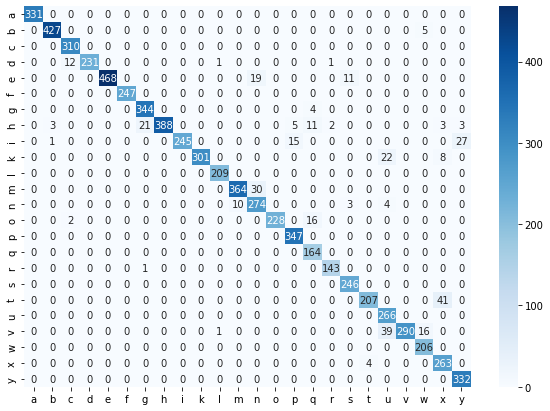

In [13]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = []
for i in range(0,26):
    if(i != 9 and i!=25):
        labels.append(chr(i+97))
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

In [14]:
from sklearn.metrics import f1_score

f1_score(y_true_labels, y_pred_labels, average='weighted')

0.9526457243452345

In [ ]:
model.summary()